In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

In [3]:
fires_db = pd.read_csv('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Fires/fire_archive_M-C61_584056.csv',
                 index_col=5,parse_dates=True)

In [6]:
fires_db.type

acq_date
2001-01-01    0
2001-01-01    1
2001-01-01    1
2001-01-01    1
2001-01-01    1
             ..
2024-11-30    0
2024-11-30    0
2024-11-30    0
2024-11-30    0
2024-11-30    0
Name: type, Length: 7240401, dtype: int64

In [3]:
fires_db = fires_db[fires_db.confidence==100]

In [4]:
fires_db = fires_db['2004':'2023']

In [5]:
def count_events(latitudes, longitudes, lat_range=(10, 90), lon_range=(-180, -30), box_size=1.0):
    """
    Creates a 2D array counting events within a variable size grid.

    Args:
        latitudes (pd.Series): Series of latitudes.
        longitudes (pd.Series): Series of longitudes.
        lat_range (tuple): Latitude range (min, max).
        lon_range (tuple): Longitude range (min, max).
        box_size (float): Size of the grid box (e.g., 1.0 for 1x1 degree, 0.5 for 0.5x0.5 degree).

    Returns:
        numpy.ndarray: 2D array with event counts.
        numpy.ndarray: array of latitude grid values
        numpy.ndarray: array of longitude grid values
    """

    lat_min, lat_max = lat_range
    lon_min, lon_max = lon_range

    lat_bins = np.arange(lat_min - box_size / 2, lat_max + box_size / 2 + box_size, box_size)
    lon_bins = np.arange(lon_min - box_size / 2, lon_max + box_size / 2 + box_size, box_size)

    lat_indices = np.digitize(latitudes, lat_bins) - 1
    lon_indices = np.digitize(longitudes, lon_bins) - 1

    # Ensure indices are within bounds
    lat_indices = np.clip(lat_indices, 0, len(lat_bins) - 2)
    lon_indices = np.clip(lon_indices, 0, len(lon_bins) - 2)

    counts = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1), dtype=int)

    for lat_idx, lon_idx in zip(lat_indices, lon_indices):
        counts[lat_idx, lon_idx] += 1

    return counts, lat_bins[:-1] + box_size / 2, lon_bins[:-1] + box_size / 2


In [6]:

# Example usage (assuming fires_db_temp is your DataFrame):
counts, lat_grid, lon_grid = count_events(
    fires_db.latitude, fires_db.longitude
)

# You can now use 'counts', 'lat_grid', and 'lon_grid' as needed.
print(counts.shape) #(80,150)
print(lat_grid.shape) #(80,)
print(lon_grid.shape) #(150,)

#Example of accessing a count.
print(counts[0,0]) # count of events in the top left pixel.

(81, 151)
(81,)
(151,)
0


In [7]:
fires_db#[(fires_db.index.month==3)|(fires_db.index.month==4)|(fires_db.index.month==5)]

,latitude,longitude,brightness,scan,track,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
acq_date,,,,,,,,,,,,,,
2004-01-01,19.4414,-92.0337,336.7,1.4,1.2,807,Aqua,MODIS,100,6.03,289.4,60.9,N,3
2004-01-01,26.8954,-81.1340,363.5,1.3,1.1,1556,Terra,MODIS,100,6.03,297.2,142.7,D,0
2004-01-01,13.5172,-87.6137,367.7,1.4,1.2,1859,Aqua,MODIS,100,6.03,310.7,157.0,D,0
2004-01-01,13.9317,-90.4106,367.5,2.2,1.4,1900,Aqua,MODIS,100,6.03,309.6,298.9,D,0
2004-01-02,16.2564,-92.4432,340.2,1.0,1.0,429,Terra,MODIS,100,6.03,291.8,44.2,N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31,10.4895,-68.1099,322.0,1.0,1.0,639,Aqua,MODIS,100,61.03,295.0,18.0,N,3
2023-12-31,10.4908,-68.1189,327.2,1.0,1.0,639,Aqua,MODIS,100,61.03,294.9,23.5,N,3
2023-12-31,17.9002,-92.4840,323.4,1.0,1.0,816,Aqua,MODIS,100,61.03,290.6,22.0,N,2


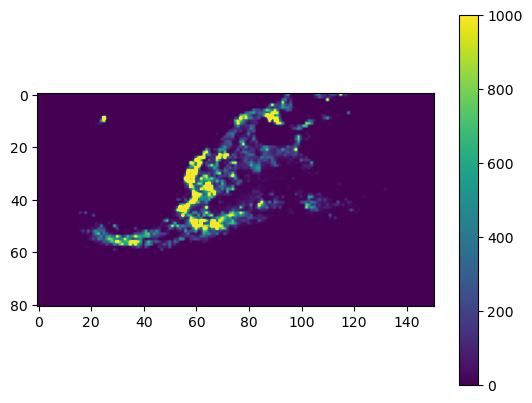

In [8]:
plt.imshow(counts,vmin=0,vmax=1000)
plt.colorbar()

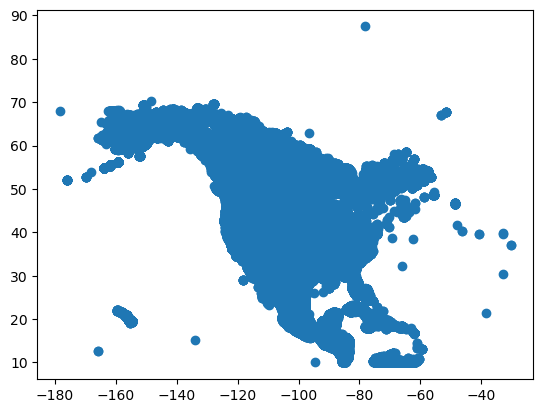

In [9]:
plt.scatter(fires_db.longitude,fires_db.latitude)

# get weather regimes

In [10]:
df_test = pd.read_csv('../ProcessZ500/labels/df_labels_nocorrfilt_ERA5.csv',
                      index_col=0,parse_dates=True)
df_test = df_test['1948-01-01':'2023-12-31']

In [11]:
df_test.loc[df_test['corr']<=0.2,'WR']=np.unique(df_test['WR'])[-1]

In [12]:
df_wrs_spring = df_test[(df_test.index.month==3)|(df_test.index.month==4)|(df_test.index.month==5)]
df_wrs_spring = df_wrs_spring['2004':'2023']

In [13]:
composites_fires_wrs = {}

for wr in range(6):
    df_temp = df_wrs_spring[df_wrs_spring['WR']==wr]
    fires_temp = fires_db.loc[df_temp.index]
    counts, lat_grid, lon_grid = count_events(
                                fires_temp.latitude, fires_temp.longitude,
                                lat_range=(20,80),
                                lon_range=(-180,-50),
                                box_size=3)
    composites_fires_wrs[wr] = counts

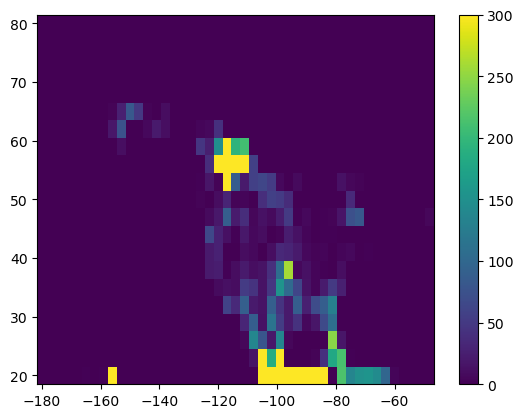

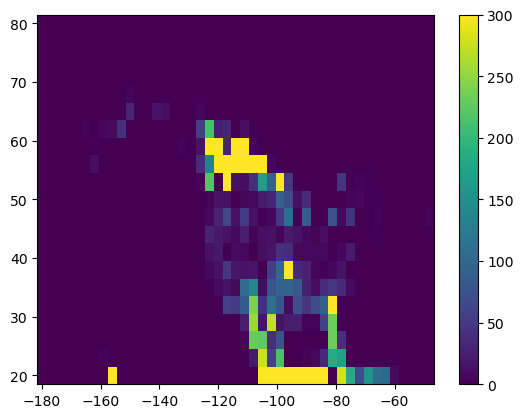

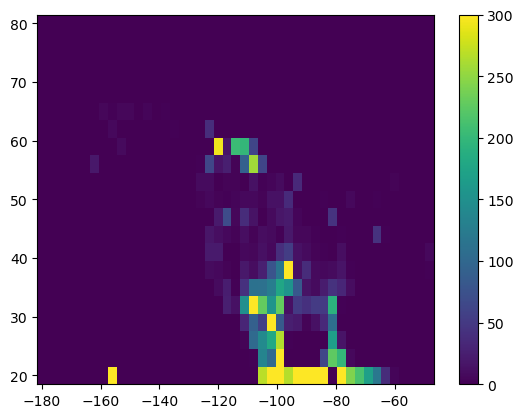

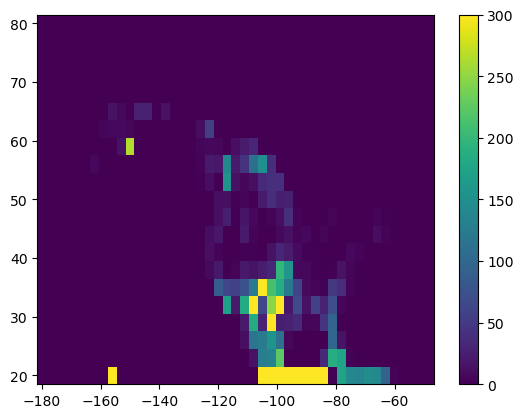

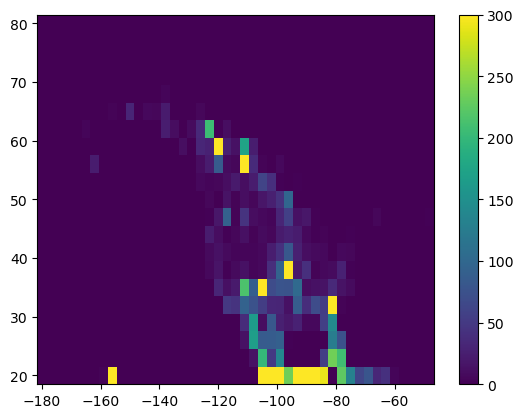

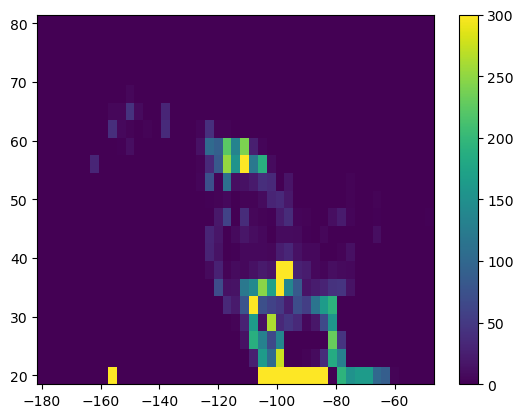

In [14]:
for wr in range(6):
    plt.pcolormesh(lon_grid,lat_grid,composites_fires_wrs[wr],vmin=0,vmax=300)
    plt.colorbar()
    plt.show()

In [15]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom
import matplotlib.path as mpath


In [16]:
names = ["Polar High", "Pacific Trough", "Pacific Ridge", "Alaskan Ridge", "Atlantic Ridge" ,"No WR"]


In [17]:
import string
abcd = list(string.ascii_lowercase)

/glade/derecho/scratch/jhayron/tmp/ipykernel_69791/548748672.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


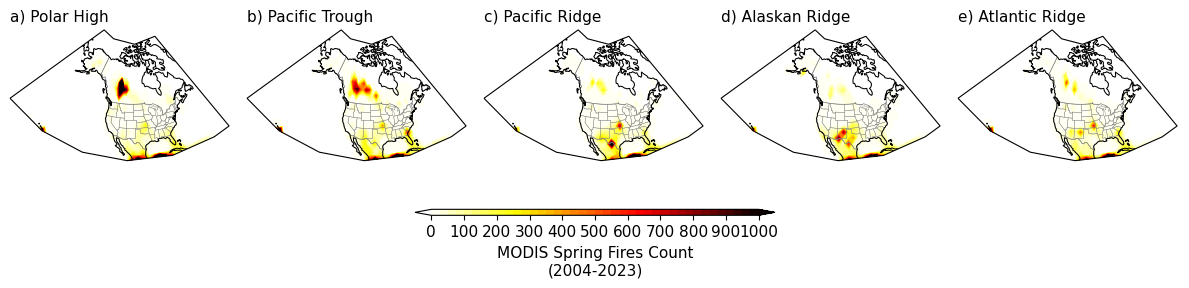

In [18]:
fig, axs = plt.subplots(
    1, 5,
    subplot_kw=dict(projection = ccrs.AlbersEqualArea(
                        central_longitude=-105,  # Center of your region
                        central_latitude=50,    # Approximate midpoint latitude
                        standard_parallels=(30, 70)  # Standard parallels
                    )
                    ),
    figsize=(12, 6))

axs_list = axs.flatten().tolist()
# ---
mini=0
maxi=1000
intervals = 41
bounds=np.linspace(mini,maxi,intervals)

for iregime in range(0,5):
    pm = axs_list[iregime].contourf(lon_grid,lat_grid,composites_fires_wrs[iregime],
                         transform=ccrs.PlateCarree(), levels=bounds,
                         vmin=mini, vmax=maxi, cmap='hot_r',extend='both')

    axs_list[iregime].set_title(
        f'{abcd[iregime]}) {names[iregime]}', 
        fontsize=11,loc='left')

    axs_list[iregime].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
    axs_list[iregime].margins(x=0, y=0)
    axs_list[iregime].add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
    axs_list[iregime].add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders


    extent = [-180, -50, 20, 80]
    # Create a rectangular boundary matching the extent
    verts = [
        (extent[0], extent[2]),  # Bottom-left corner
        (extent[1], extent[2]),  # Bottom-right corner
        (extent[1], extent[3]),  # Top-right corner
        (extent[0], extent[3]),  # Top-left corner
        (extent[0], extent[2])   # Closing the rectangle
    ]
    rect = mpath.Path(verts)
    
    # Set the boundary of the plot
    axs_list[iregime].set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.35, 0.3, 0.3,0.01])
ticks_1 = np.arange(mini,maxi+0.00001,100)
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                    orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=11)
cbar.set_label('MODIS Spring Fires Count\n(2004-2023)', fontsize=11)
plt.tight_layout()

# winter and spring

In [19]:
df_test = pd.read_csv('../ProcessZ500/labels/df_labels_nocorrfilt_ERA5.csv',
                      index_col=0,parse_dates=True)
df_test = df_test['1948-01-01':'2023-12-31']

In [20]:
df_test.loc[df_test['corr']<=0.2,'WR']=np.unique(df_test['WR'])[-1]

In [21]:
df_wrs_seasonal = df_test[(df_test.index.month>=12)|(df_test.index.month<=5)]
df_wrs_seasonal = df_wrs_seasonal['2004':'2023']

In [30]:
composites_fires_wrs = {}

for wr in range(6):
    df_temp = df_wrs_seasonal[df_wrs_seasonal['WR']==wr]
    fires_temp = fires_db.loc[fires_db.index.intersection(df_temp.index)]
    counts, lat_grid, lon_grid = count_events(
                                fires_temp.latitude, fires_temp.longitude,
                                lat_range=(20,80),
                                lon_range=(-180,-50),
                                box_size=3)
    composites_fires_wrs[wr] = counts

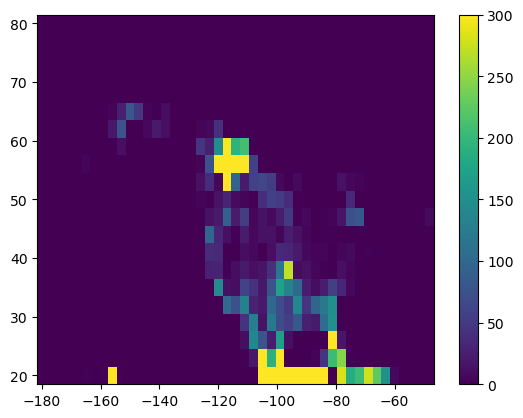

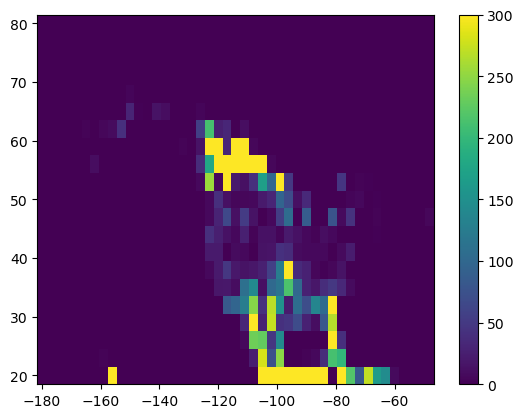

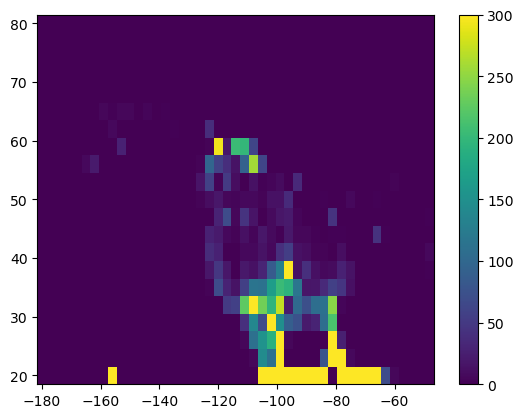

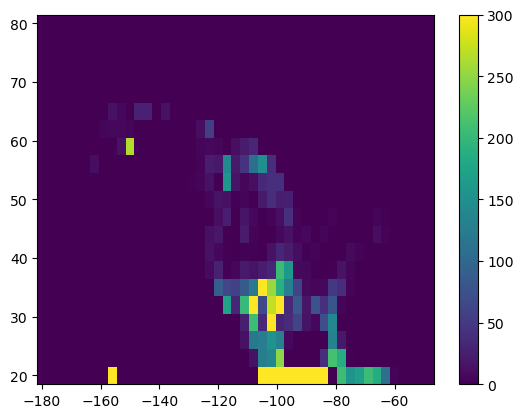

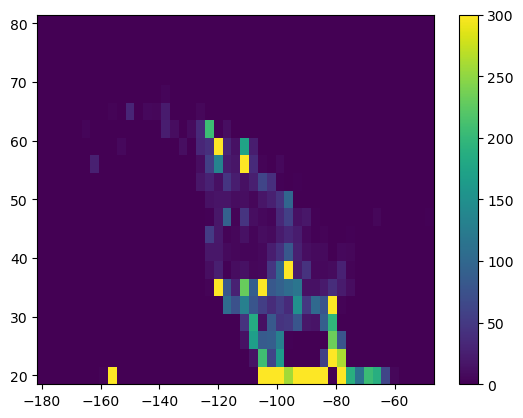

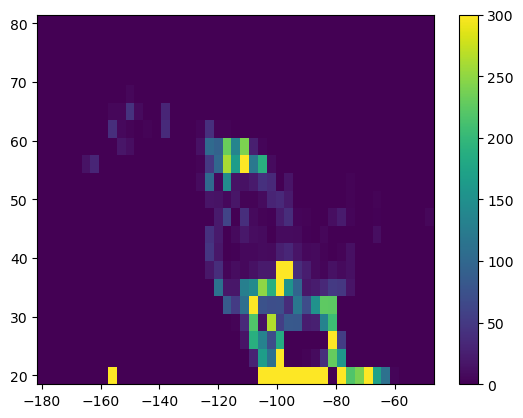

In [31]:
for wr in range(6):
    plt.pcolormesh(lon_grid,lat_grid,composites_fires_wrs[wr],vmin=0,vmax=300)
    plt.colorbar()
    plt.show()

In [32]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom
import matplotlib.path as mpath


In [33]:
names = ["Polar High", "Pacific Trough", "Pacific Ridge", "Alaskan Ridge", "Atlantic Ridge" ,"No WR"]


In [34]:
import string
abcd = list(string.ascii_lowercase)

/glade/derecho/scratch/jhayron/tmp/ipykernel_69791/548748672.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


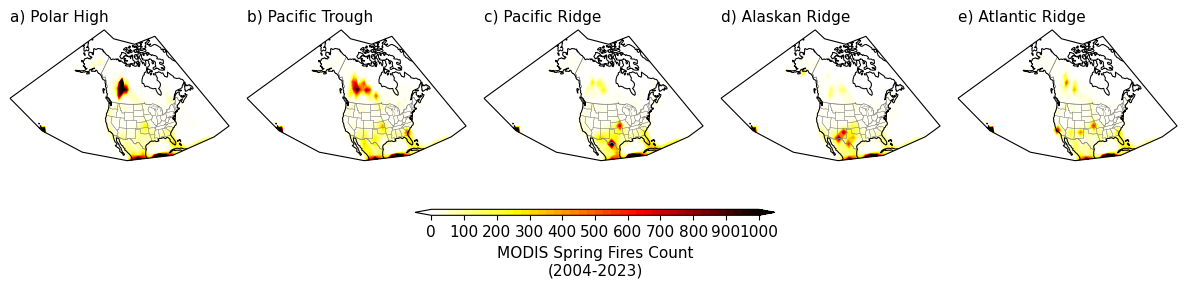

In [35]:
fig, axs = plt.subplots(
    1, 5,
    subplot_kw=dict(projection = ccrs.AlbersEqualArea(
                        central_longitude=-105,  # Center of your region
                        central_latitude=50,    # Approximate midpoint latitude
                        standard_parallels=(30, 70)  # Standard parallels
                    )
                    ),
    figsize=(12, 6))

axs_list = axs.flatten().tolist()
# ---
mini=0
maxi=1000
intervals = 41
bounds=np.linspace(mini,maxi,intervals)

for iregime in range(0,5):
    pm = axs_list[iregime].contourf(lon_grid,lat_grid,composites_fires_wrs[iregime],
                         transform=ccrs.PlateCarree(), levels=bounds,
                         vmin=mini, vmax=maxi, cmap='hot_r',extend='both')

    axs_list[iregime].set_title(
        f'{abcd[iregime]}) {names[iregime]}', 
        fontsize=11,loc='left')

    axs_list[iregime].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
    axs_list[iregime].margins(x=0, y=0)
    axs_list[iregime].add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
    axs_list[iregime].add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders


    extent = [-180, -50, 20, 80]
    # Create a rectangular boundary matching the extent
    verts = [
        (extent[0], extent[2]),  # Bottom-left corner
        (extent[1], extent[2]),  # Bottom-right corner
        (extent[1], extent[3]),  # Top-right corner
        (extent[0], extent[3]),  # Top-left corner
        (extent[0], extent[2])   # Closing the rectangle
    ]
    rect = mpath.Path(verts)
    
    # Set the boundary of the plot
    axs_list[iregime].set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.35, 0.3, 0.3,0.01])
ticks_1 = np.arange(mini,maxi+0.00001,100)
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                    orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=11)
cbar.set_label('MODIS Spring Fires Count\n(2004-2023)', fontsize=11)
plt.tight_layout()

In [38]:
composites_fires_wrs

{0: array([[   0,    0,    0,    0,    0,    2,    0,    2, 2355,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,  833, 1754,  841,  452, 2337, 3739, 1265,  702,
            0,  282,  185,  204,  278,  225,  151,    6,    0,    0,    0,
            0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    2,   18,  308,  192,  387,    0,    0,    1,    3,   46,
          204,  246,    2,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,   10,  140,   80,   23,  167,   11,    0,    1,    0,    0,
          379,   17,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   0,    0,    0,    0,    0,    0,    0